# Stanford Cars - Experiment: Ranger913A

Ran 8 experiments with Ranger913A to explore any difference in performance to "vanilla" Ranger by tweaking lr, wd and start_pct. No improvement in accuracy was found at best it matched the performance of vanilla ranger (93.8%). EfficienetNet with Mish was used with fit_fc to control the learning schedule.

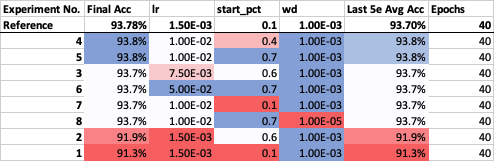

# Plot Validation Accuracy

Note that the plots of Trial 5 are missing due overwriting the file with the results from Trial 8 :(

In [39]:
li = []

for filename in fnames:
    df = pd.read_csv(filename, index_col=0, header=0)
    li.append(df.iloc[:,1])
    #print(df.iloc[:,0].head())

# Add a reference run from Vanilla Ranger:
df = pd.read_csv('val_loss_and_acc_mefficient_b3_ranger_40e_15e4_wd1e-3_10pct_start_run5_2019-09_04_val_loss_and_acc.csv',
                 index_col=0, header=0)
li.append(df.iloc[:,1])

# Combine all results into a single df
frame = pd.concat(li, axis=1, ignore_index=True)

# Rename columns according to their trial number
frame.columns = ['trial7', 'trial4','trial8','trial2','trial1','trial6','trial3', 'reference']


# Sort columns by column name
frame = frame.reindex(sorted(frame.columns), axis=1)

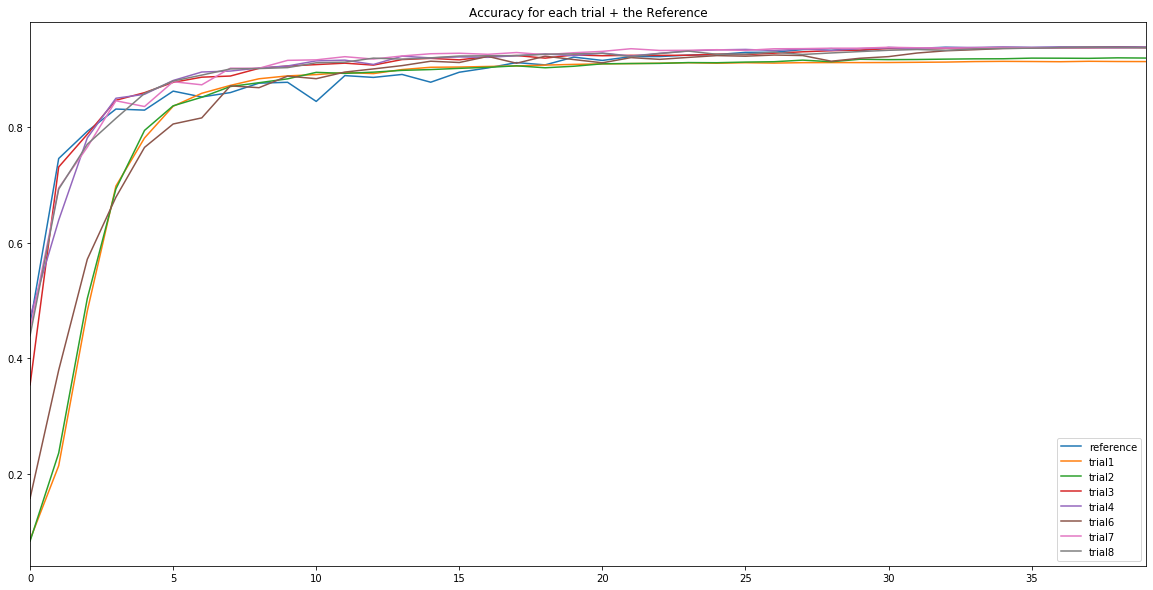

In [40]:
frame.plot()
plt.title('Accuracy for each trial + the Reference')
plt.show()

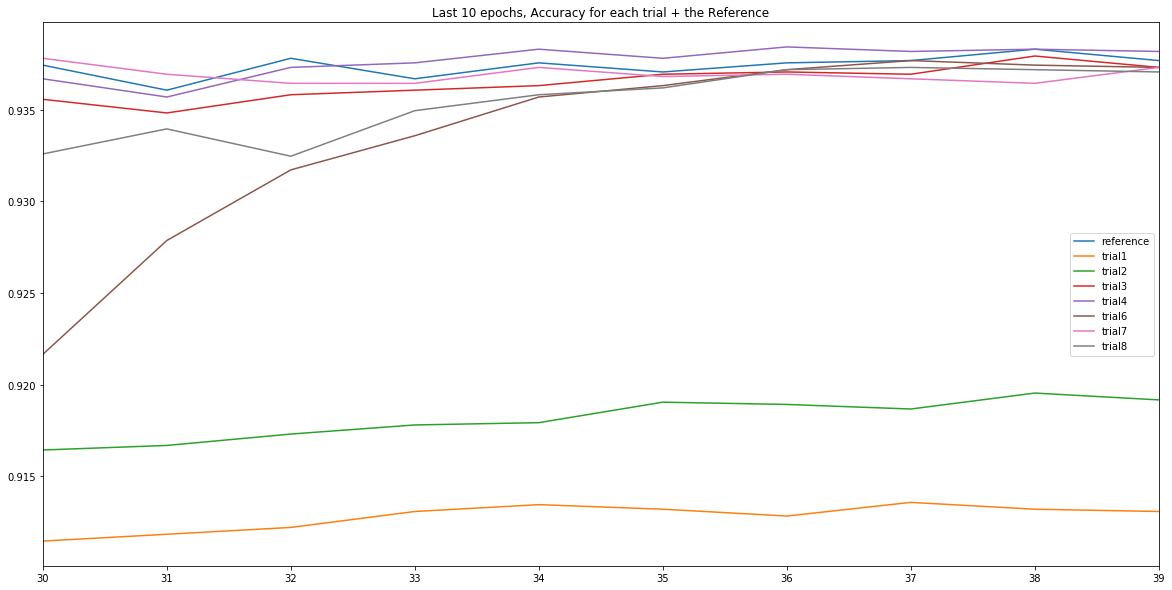

In [41]:
frame.iloc[30:,:].plot()
plt.title('Last 10 epochs, Accuracy for each trial + the Reference')
plt.show()

# Plot Validation Losses

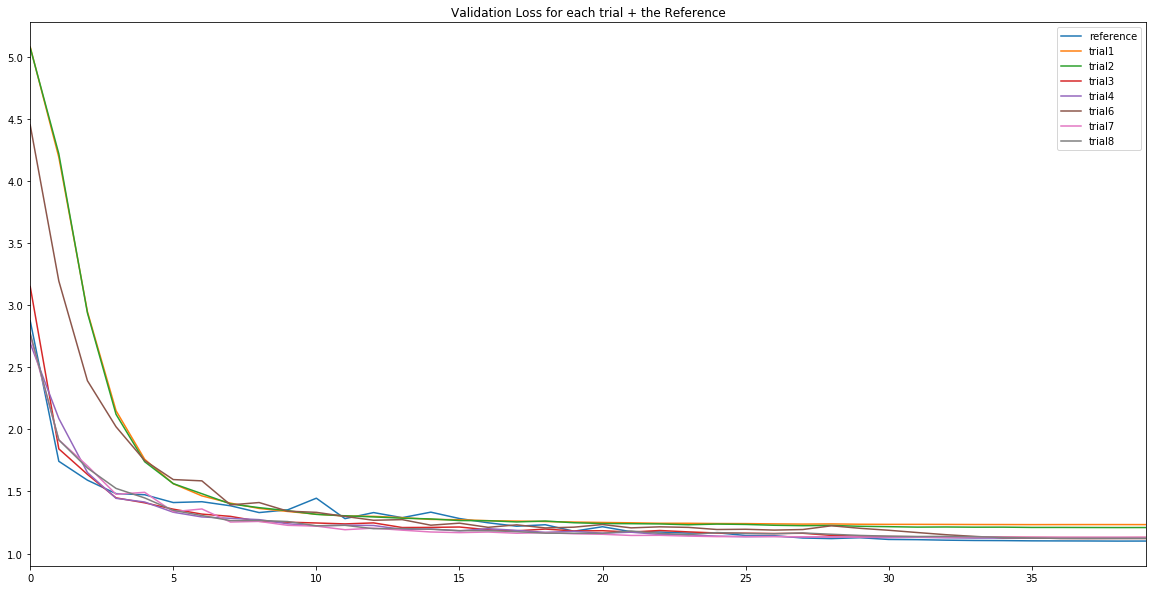

In [36]:
li = []

for filename in fnames:
    df = pd.read_csv(filename, index_col=0, header=0)
    li.append(df.iloc[:,0])
    #print(df.iloc[:,0].head())

# Add a reference run from Vanilla Ranger:
df = pd.read_csv('val_loss_and_acc_mefficient_b3_ranger_40e_15e4_wd1e-3_10pct_start_run5_2019-09_04_val_loss_and_acc.csv',
                 index_col=0, header=0)
li.append(df.iloc[:,0])

# Combine all results into a single df
frame = pd.concat(li, axis=1, ignore_index=True)

# Rename columns according to their trial number
frame.columns = ['trial7', 'trial4','trial8','trial2','trial1','trial6','trial3', 'reference']


# Sort columns by column name
frame = frame.reindex(sorted(frame.columns), axis=1)

frame.plot()
plt.title('Validation Loss for each trial + the Reference')
plt.show()

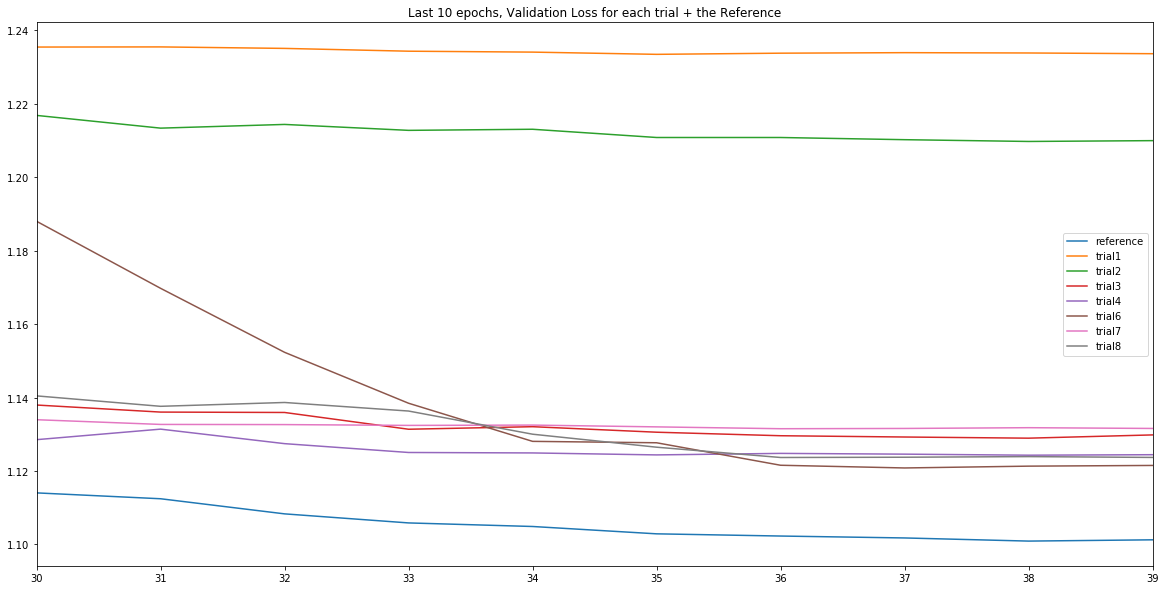

In [37]:
frame.iloc[30:,:].plot()
plt.title('Last 10 epochs, Validation Loss for each trial + the Reference')
plt.show()

In [38]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

from fastai import *
from fastai.vision import *
from fastai.utils.mem import *

# Modified version of @lukemelas' EfficientNet implementation with Mish instead of Swish activation
from MEfficientNet_PyTorch.efficientnet_pytorch import EfficientNet as MEfficientNet

# @lessw2020 implementation : https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
# Import Beta version
from ranger913A import Ranger
from helper_functions import compare_most_confused, compare_top_losses, show_img


plt.rcParams["figure.figsize"] = (20,10)

## Getting the Data

In [2]:
path = 'data/stanford-cars/'
labels_df = pd.read_csv('labels_df.csv')
labels_df.head(3)

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test,filename_cropped,bbox_h,bbox_w
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0,cropped_00001.jpg,260,531
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0,cropped_00002.jpg,472,833
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0,cropped_00003.jpg,273,517


Lets look closer at the data, how many class_ids do we have? Does it match the number of class names?

## Data Loading
Used the standard fastai image transforms and held out 20% of the training data for validation.

In [3]:
def get_data(SZ:int=299, do_cutout:bool=False, p_cutout:float=0.75):
    SEED = 42
    LABEL = 'class_name'
    
    if do_cutout == True:
        cutout_tfm = cutout(n_holes=(1,2), length=(100, 100), p=p_cutout)
        car_tfms = get_transforms(xtra_tfms=[cutout_tfm])
    else: car_tfms = get_transforms()

    #tfms = get_transforms()

    trn_labels_df = labels_df.loc[labels_df['is_test']==0, ['filename', 'class_name', 'class_id']].copy()

    src = (ImageList.from_df(trn_labels_df, path, folder='train', cols='filename')
                        .split_by_rand_pct(valid_pct=0.2, seed=SEED)
                        .label_from_df(cols=LABEL))

    data = (src.transform(car_tfms, 
                          size=SZ,  
                          resize_method=ResizeMethod.SQUISH, 
                          padding_mode='reflection')
                .databunch()
                .normalize(imagenet_stats))
    
    # Get test data
    TEST_SZ = 299
    src_test = (ImageList.from_df(labels_df, path, folder='merged', cols='filename')
           # the 'is_test' column has values of 1 for the test set
           .split_from_df(col='is_test')
           .label_from_df(cols=LABEL))

    data_test = (src_test.transform(car_tfms, 
                                  size=SZ,  
                                  resize_method=ResizeMethod.SQUISH, 
                                  padding_mode='reflection')
                .databunch()
                .normalize(imagenet_stats))
    
    return data, data_test, src, src_test, car_tfms

data, data_test, src, src_test, car_tfms = get_data(do_cutout=False)

### Flat and cosine annealer

In [4]:
# By @muellerzr on the fastai forums:
# https://forums.fast.ai/t/meet-mish-new-activation-function-possible-successor-to-relu/53299/133       

from fastai.callbacks import *

def FlatCosAnnealScheduler(learn, lr:float=4e-3, tot_epochs:int=1, moms:Floats=(0.95,0.999),
                          start_pct:float=0.72, curve='cosine'):
    "Manage FCFit trainnig as found in the ImageNette experiments"
    n = len(learn.data.train_dl)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":
        curve_type=annealing_cos
    elif curve=="linear":
        curve_type=annealing_linear
    elif curve=="exponential":
        curve_type=annealing_exp
    else:
        raiseValueError(f"annealing type not supported {curve}")

    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr).schedule_hp('mom', moms[0])
    phase1 = TrainingPhase(batch_finish).schedule_hp('lr', lr, anneal=curve_type).schedule_hp('mom', moms[1])
    phases = [phase0, phase1]
    return GeneralScheduler(learn, phases)
                
def fit_fc(learn:Learner, tot_epochs:int=None, lr:float=defaults.lr,  moms:Tuple[float,float]=(0.95,0.85), start_pct:float=0.72,
                  wd:float=None, callbacks:Optional[CallbackList]=None, show_curve:bool=False)->None:
    "Fit a model with Flat Cosine Annealing"
    max_lr = learn.lr_range(lr)
    callbacks = listify(callbacks)
    callbacks.append(FlatCosAnnealScheduler(learn, lr, moms=moms, start_pct=start_pct, tot_epochs=tot_epochs))
    learn.fit(tot_epochs, max_lr, wd=wd, callbacks=callbacks)

## Save Metrics

In [5]:
def save_metrics_to_csv(exp_name, run_count, learn, metrics):
    for m in metrics:
        name = f'{m}_{exp_name}_run{str(run_count)}_2019-09_04'

        ls = []
        if m == 'val_loss_and_acc':
            acc = []
            for l in learn.recorder.metrics:
                 acc.append(l[0].item())
            ls = learn.recorder.val_losses 

            d = {name: ls, 'acc': acc}
            df = pd.DataFrame(d)
            #df.columns = [name, 'acc']
        elif m == 'trn_loss':
            for l in learn.recorder.losses:
                ls.append(l.item())
            df = pd.DataFrame(ls)
            df.columns = [name]

        df.to_csv(f'{name}_{m}.csv')
        print(df.head())

# Trial 1 - Ranger913A, same as 93.8% RangerMish runs

In [7]:
effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(1536, data.c)
    return model

mish_model = getMishModel(data, effnet_b3) 

Loaded pretrained weights for efficientnet-b3


In [10]:
exp_name = 'mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=15e-4, start_pct=0.10, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time
0,5.169999,5.077199,0.086432,04:53
1,4.502159,4.189459,0.214152,04:53
2,3.304076,2.946711,0.481781,04:51
3,2.371112,2.149920,0.697799,04:52
4,1.868769,1.759128,0.780997,04:53
5,1.575352,1.562613,0.835841,04:53
6,1.383841,1.464737,0.858227,04:53
7,1.320441,1.406380,0.871906,04:52
8,1.219045,1.363591,0.883348,04:52
9,1.164985,1.339339,0.888322,04:53


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   trn_loss_mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start_run1_2019-09_04
0                                           5.273360                            
1                                           5.259253                            
2                                           5.276084                            
3                                           5.285175                            
4                                           5.292523                            
   val_loss_and_acc_mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start_run1_2019-09_04  \
0                                           5.077199                                       
1                                           4.189459                                       
2                                           2.946711                                       
3                                           2.149920                                       
4                                           1.759128  

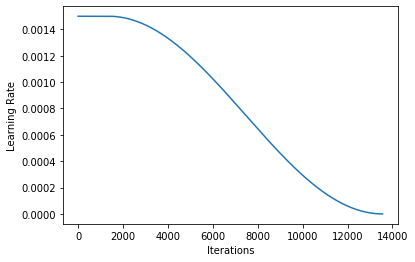

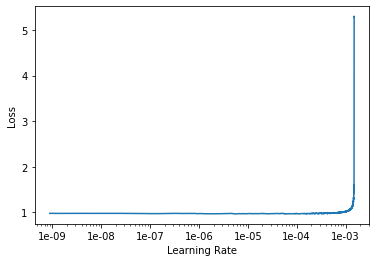

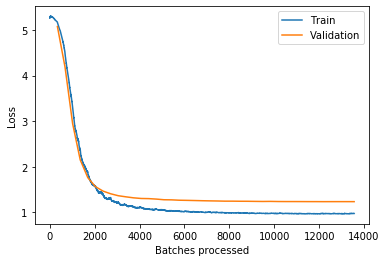

In [11]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

# Trial 2 - Ranger913A - longer flat

In [8]:
effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(1536, data.c)
    return model

mish_model = getMishModel(data, effnet_b3) 

Loaded pretrained weights for efficientnet-b3


In [9]:
exp_name = 'mefficient_b3_ranger913A_40e_15e4_wd1e-3_60pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=15e-4, start_pct=0.60, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

### Ran the above again by mistake, best results were up at 91.9% for the last 5-7 epoches

In [ ]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

# Trial 3 - Ranger913A - Higher LR, long flat

In [7]:
effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(1536, data.c)
    return model

mish_model = getMishModel(data, effnet_b3) 

Loaded pretrained weights for efficientnet-b3


In [8]:
exp_name = 'mefficient_b3_ranger913A_40e_75e4_wd1e-3_60pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=75e-4, start_pct=0.60, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time
0,3.820927,3.148995,0.354185,04:59
1,1.965611,1.842941,0.730755,05:00
2,1.506152,1.637873,0.787340,04:59
3,1.307723,1.448728,0.846163,05:02
4,1.192281,1.408901,0.859346,05:00
5,1.122218,1.357735,0.877130,05:01
6,1.082875,1.318053,0.886084,05:01
7,1.053568,1.299803,0.888074,05:00
8,1.018498,1.259790,0.901380,05:01
9,1.001908,1.253024,0.905360,05:01


   trn_loss_mefficient_b3_ranger913A_40e_75e4_wd1e-3_60pct_start_run1_2019-09_04
0                                           5.248847                            
1                                           5.300742                            
2                                           5.290440                            
3                                           5.296983                            
4                                           5.292651                            
   val_loss_and_acc_mefficient_b3_ranger913A_40e_75e4_wd1e-3_60pct_start_run1_2019-09_04  \
0                                           3.148995                                       
1                                           1.842941                                       
2                                           1.637873                                       
3                                           1.448728                                       
4                                           1.408901  

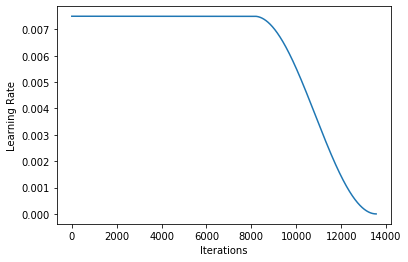

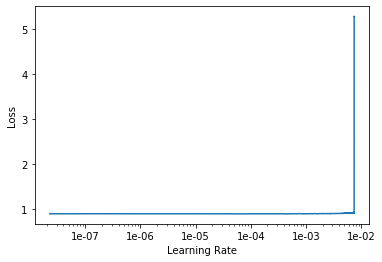

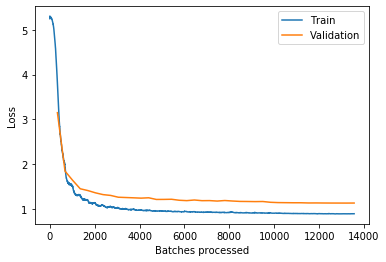

In [9]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

# Trial 4 - Ranger913A - Higher LR, short flat

In [7]:
effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(1536, data.c)
    return model

mish_model = getMishModel(data, effnet_b3) 

Loaded pretrained weights for efficientnet-b3


In [8]:
exp_name = 'mefficient_b3_ranger913A_40e_1e-2_wd1e-3_40pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=1e-2, start_pct=0.40, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time
0,3.394045,2.692783,0.471956,04:56
1,1.877921,2.087465,0.638727,04:53
2,1.524102,1.652535,0.781122,04:53
3,1.333837,1.444941,0.849646,04:53
4,1.195229,1.415430,0.856485,04:52
5,1.116071,1.333086,0.880363,04:59
6,1.065620,1.295162,0.895038,05:04
7,1.048423,1.284246,0.896655,05:04
8,1.016334,1.273556,0.902002,05:05
9,0.998054,1.240093,0.905484,05:06


   trn_loss_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_40pct_start_run1_2019-09_04
0                                           5.297081                            
1                                           5.280595                            
2                                           5.292503                            
3                                           5.303558                            
4                                           5.310473                            
   val_loss_and_acc_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_40pct_start_run1_2019-09_04  \
0                                           2.692783                                       
1                                           2.087465                                       
2                                           1.652535                                       
3                                           1.444941                                       
4                                           1.415430  

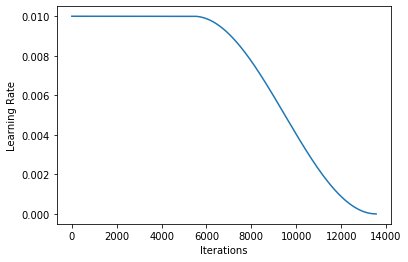

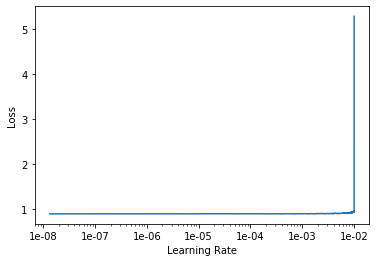

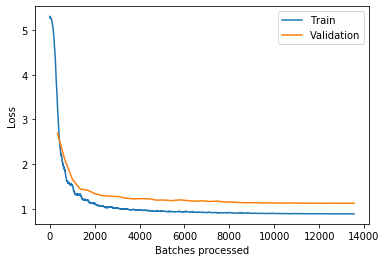

In [9]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

# Trial 5 - Ranger913A - Higher LR, long flat

In [7]:
effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name, num_classes=data.c)
    return model

mish_model = getMishModel(data_test, effnet_b3) 

Loaded pretrained weights for efficientnet-b3


In [8]:
exp_name = 'mefficient_b3_ranger913A_40e_1e-2_wd1e-3_70pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=1e-2, start_pct=0.70, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time
0,3.400483,2.871765,0.413257,04:52
1,1.907865,1.971886,0.679144,04:52
2,1.522500,1.674924,0.770675,04:52
3,1.307706,1.511252,0.823405,04:51
4,1.202457,1.425055,0.855117,04:52
5,1.137008,1.375492,0.872031,04:51
6,1.061780,1.336155,0.881109,04:52
7,1.038827,1.280181,0.901878,04:53
8,1.014898,1.252811,0.906604,04:52
9,0.997383,1.247733,0.904987,04:53


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   trn_loss_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_70pct_start_run1_2019-09_04
0                                           5.319709                            
1                                           5.304628                            
2                                           5.299093                            
3                                           5.305320                            
4                                           5.304634                            
   val_loss_and_acc_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_70pct_start_run1_2019-09_04  \
0                                           2.871765                                       
1                                           1.971886                                       
2                                           1.674924                                       
3                                           1.511252                                       
4                                           1.425055  

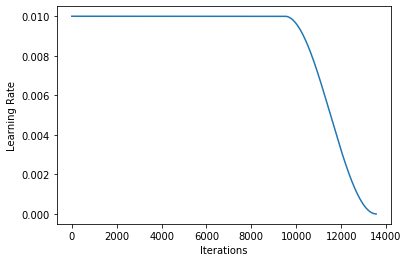

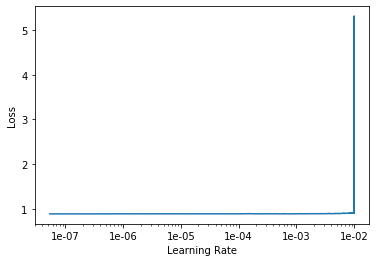

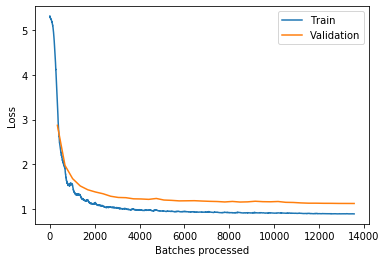

In [9]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

# Trial 6 - Ranger913A - Higher Higher LR, long flat

In [9]:
effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name, num_classes=data.c)
    return model

mish_model = getMishModel(data_test, effnet_b3) 

Loaded pretrained weights for efficientnet-b3


In [10]:
exp_name = 'mefficient_b3_ranger913A_40e_5e-2_wd1e-3_70pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=5e-2, start_pct=0.70, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time
0,3.186935,4.448779,0.157941,05:07
1,2.460164,3.193780,0.379430,05:07
2,1.949369,2.391295,0.571198,05:06
3,1.672574,2.020544,0.678523,05:07
4,1.500015,1.749178,0.764706,05:19
5,1.381144,1.595956,0.805124,05:22
6,1.257888,1.585583,0.815695,05:20
7,1.186148,1.392374,0.871036,05:17
8,1.153069,1.411106,0.867927,05:07
9,1.114458,1.341712,0.887949,05:07


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   trn_loss_mefficient_b3_ranger913A_40e_5e-2_wd1e-3_70pct_start_run1_2019-09_04
0                                           5.317888                            
1                                           5.297764                            
2                                           5.282902                            
3                                           5.284739                            
4                                           5.279593                            
   val_loss_and_acc_mefficient_b3_ranger913A_40e_5e-2_wd1e-3_70pct_start_run1_2019-09_04  \
0                                           4.448779                                       
1                                           3.193780                                       
2                                           2.391295                                       
3                                           2.020544                                       
4                                           1.749178  

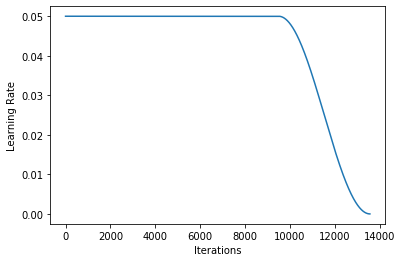

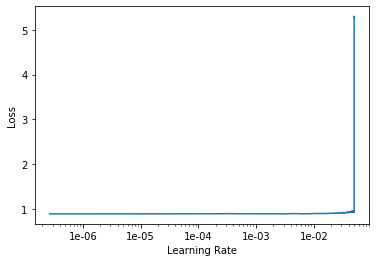

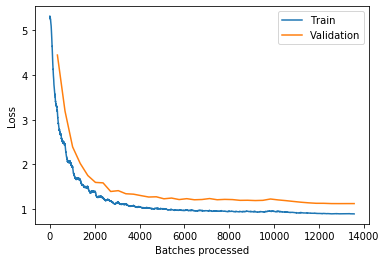

In [11]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

# Trial 7 - Ranger913A - Higher LR, short flat

In [6]:
effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name, num_classes=data.c)
    return model

mish_model = getMishModel(data_test, effnet_b3) 

Loaded pretrained weights for efficientnet-b3


In [7]:
exp_name = 'mefficient_b3_ranger913A_40e_1e-2_wd1e-3_10pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=1e-2, start_pct=0.10, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time
0,3.379399,2.753635,0.451188,05:05
1,1.909714,1.915781,0.694441,05:04
2,1.531512,1.706265,0.764955,05:06
3,1.310071,1.477752,0.845293,05:05
4,1.193389,1.493313,0.835344,05:07
5,1.139984,1.337414,0.878249,05:06
6,1.073058,1.359411,0.872901,05:06
7,1.034839,1.254205,0.901629,05:06
8,1.027029,1.259341,0.901505,05:06
9,0.993512,1.227714,0.915185,05:05


   trn_loss_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_10pct_start_run1_2019-09_04
0                                           5.275301                            
1                                           5.299798                            
2                                           5.291434                            
3                                           5.296481                            
4                                           5.302769                            
   val_loss_and_acc_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_10pct_start_run1_2019-09_04  \
0                                           2.753635                                       
1                                           1.915781                                       
2                                           1.706265                                       
3                                           1.477752                                       
4                                           1.493313  

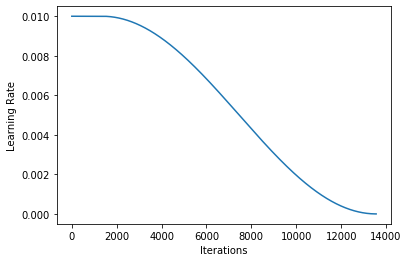

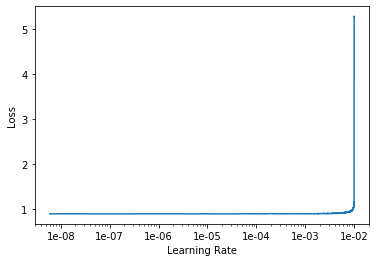

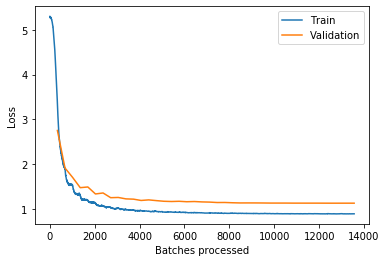

In [8]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

# Trial 8 - Ranger913A - Higher LR, long flat, lower WD

In [6]:
effnet_b3 = 'efficientnet-b3'
def getMishModel(data, model_name):
    model = MEfficientNet.from_pretrained(model_name, num_classes=data.c)
    return model

mish_model = getMishModel(data_test, effnet_b3) 

Loaded pretrained weights for efficientnet-b3


In [7]:
exp_name = 'mefficient_b3_ranger913A_40e_1e-2_wd1e-3_70pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-5,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=1e-2, start_pct=0.70, wd=1e-5, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time
0,3.312960,2.773821,0.439124,05:12
1,1.905874,1.914895,0.692451,05:22
2,1.510051,1.688699,0.770053,05:12
3,1.333398,1.524735,0.814948,05:25
4,1.210485,1.448197,0.857978,05:27
5,1.129552,1.348059,0.879493,05:32
6,1.099443,1.306483,0.889690,05:28
7,1.049398,1.265751,0.900385,05:30
8,1.016842,1.267413,0.901007,05:28
9,1.007013,1.258207,0.902624,05:29


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   trn_loss_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_70pct_start_run1_2019-09_04
0                                           5.315958                            
1                                           5.312421                            
2                                           5.299706                            
3                                           5.290897                            
4                                           5.295061                            
   val_loss_and_acc_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_70pct_start_run1_2019-09_04  \
0                                           2.773821                                       
1                                           1.914895                                       
2                                           1.688699                                       
3                                           1.524735                                       
4                                           1.448197  

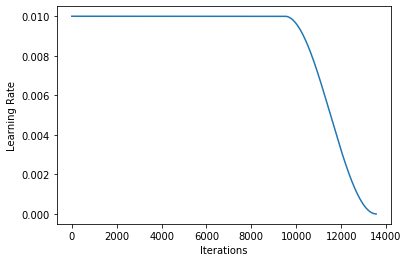

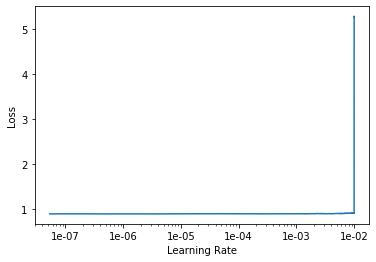

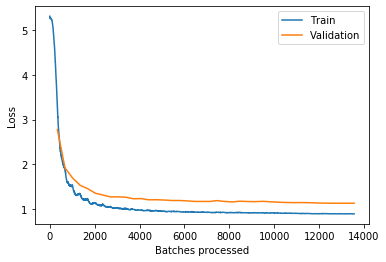

In [8]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

# Reference run from "classic" Ranger (v9.3.19)
A previous average of 5 runs with these parameters gave an average accuracy of 93.8%

In [14]:
exp_name = 'mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start'
metrics = ['trn_loss', 'val_loss_and_acc']

#Adding Mish activation to EfficientNet-b3 meant reducing bs from 32 -> 24
data_test.batch_size = 24

# Manually restarted the gpu kernel and changed the run count as weights seemed to be being saved between runs
run_count = 1

learn = Learner(data_test, 
                model=mish_model,
                wd = 1e-3,
                opt_func=Ranger,
                bn_wd=False,
                true_wd=True,
                metrics=[accuracy],
                loss_func=LabelSmoothingCrossEntropy()
               ).to_fp16()

fit_fc(learn, tot_epochs=40, lr=15e-4, start_pct=0.10, wd=1e-3, show_curve=False)

learn.save(f'exp_{exp_name}_run{run_count}')

# SAVE METRICS
save_metrics_to_csv(exp_name, run_count, learn, metrics)

epoch,train_loss,valid_loss,accuracy,time
0,3.728042,2.873347,0.458774,04:38
1,1.944554,1.743006,0.745430,04:38
2,1.516537,1.591039,0.792439,04:38
3,1.334032,1.482762,0.830991,04:38
4,1.264926,1.473987,0.829126,04:38
5,1.249027,1.411017,0.861957,04:38
6,1.190200,1.417674,0.851884,04:38
7,1.150759,1.384996,0.859470,04:38
8,1.098737,1.330367,0.875762,04:37
9,1.102312,1.352557,0.877254,04:39


   trn_loss_mefficient_b3_ranger_40e_15e4_wd1e-3_10pct_start_run5_2019-09_04
0                                           5.269136                        
1                                           5.274109                        
2                                           5.290759                        
3                                           5.294561                        
4                                           5.287923                        
   val_loss_and_acc_mefficient_b3_ranger_40e_15e4_wd1e-3_10pct_start_run5_2019-09_04  \
0                                           2.873347                                   
1                                           1.743006                                   
2                                           1.591039                                   
3                                           1.482762                                   
4                                           1.473987                                   

        a

## Checking filenames saved

Forgot to change the filename for Trial 8, so "...1e-2_wd1e-3_70pct_start..." should actually be " 1e-2_wd1e-5_70pct_start...". As a result, the results of Trial 5 were overwritten by Trial 8

In [22]:
from os import listdir
from os.path import isfile, join

mypath = '.'
fnames = [f for f in listdir(mypath) if 'val_loss_and_acc_mefficient_b3_ranger913A' in (join(mypath, f))]
fnames

for filename in fnames:
    print(filename)

val_loss_and_acc_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_10pct_start_run1_2019-09_04_val_loss_and_acc.csv
val_loss_and_acc_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_40pct_start_run1_2019-09_04_val_loss_and_acc.csv
val_loss_and_acc_mefficient_b3_ranger913A_40e_1e-2_wd1e-3_70pct_start_run1_2019-09_04_val_loss_and_acc.csv
val_loss_and_acc_mefficient_b3_ranger913A_40e_15e4_wd1e-3_60pct_start_run1_2019-09_04_val_loss_and_acc.csv
val_loss_and_acc_mefficient_b3_ranger913A_40e_15e4_wd1e-3_10pct_start_run1_2019-09_04_val_loss_and_acc.csv
val_loss_and_acc_mefficient_b3_ranger913A_40e_5e-2_wd1e-3_70pct_start_run1_2019-09_04_val_loss_and_acc.csv
val_loss_and_acc_mefficient_b3_ranger913A_40e_75e4_wd1e-3_60pct_start_run1_2019-09_04_val_loss_and_acc.csv
